## Preliminary study of early-2020 mortality data over Italy

The purpose of this notebook is to reproduce (rather faithfully) the original study by **F. Ricciato (@Eurostat)** as available on [CROS portal](https://ec.europa.eu/eurostat/cros/content/preliminary-view-2020-mortality-data-istat) and entitled:

In [1]:
COUNTRY = "IT"
YEAR = 2020
PROVIDER = "ISTAT"
print('"\033[1mA preliminary view at %s mortality data from %s\033[0m"' % (YEAR, PROVIDER))

"A preliminary view at 2020 mortality data from ISTAT"


The notebook will not discuss methodological choices. Please refer to the original study. The notebook does not aim at performance either, still it is generic enough to be repurposed for different similar datasets as long as metadata are made available.

Concerning the extraction of the data, while the latest available version of the above mentioned study is from April 16th, please note:

In [2]:
from datetime import datetime
print("Last update/running of this notebook: \033[1m%s\033[0m" % datetime.today())

Last update/running of this notebook: 2020-05-05 17:46:21.380980


### Setting and checking the environment first

Let's run some setup necessary to import the dependency(ies) required to run the project... First, some generic packages, including a few to handle date/time data since we deal with timeseries:

In [3]:
import os, sys
import json
import time
from datetime import timedelta # and datetime above
import calendar

Essential for the running of the notebook, besides the basic [`numpy`](https://numpy.org) package, is the [`pandas`](https://pandas.pydata.org) package use for common data handling and processing:

In [4]:
import numpy as np
try:
    import pandas as pd
except ImportError:
    try:
        !{sys.executable} -m pip install pandas
    except:
        raise IOError("!!! Sorry, you're doomed, you won't be able to run this notebook... !!!")
    else:
        print("! Package pandas installed on-the-fly !")

In [5]:
# %%bash # testing google-colab for instance
# [[ ! -e /colabtools ]] && exit
# `which python` -m pip install pandas

Note that the  [`geopandas`](https://geopandas.org) package is also used as far as basic 'geoprocessing' goes:

In [6]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")

You will also need to import the [`pyeudatnat`](https://github.com/eurostat/pyEUDatNat) package that contains various useful functions/methods for metadata-based data ingestion: 

In [7]:
try:
    import pyeudatnat
except ImportError:
    try:
        # import google.colab
        !{sys.executable} -m pip install git+https://github.com/eurostat/pyeudatnat.git
        # !{sys.executable} -m pip install pyeudatnat
    except:
        raise IOError("Sorry, you're doomed: package pyeudatnat not installed !")
    else:
        print("! Package pyeudatnat installed on-the-fly !")
        
try:
    from pyeudatnat.base import datnatFactory
    from pyeudatnat.misc import Structure
    from pyeudatnat.misc import Type, Datetime
except:
    pass

/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/geo.py:48: UserWarning: 
! Missing happygisco package (https://github.com/eurostat/happyGISCO) - GISCO web services not available !
  warnings.warn('\n! Missing happygisco package (https://github.com/eurostat/happyGISCO) - GISCO web services not available !')


Last, we will use the [`matplotlib`](https://matplotlib.org) package to render the various illustrations of the original study:

In [8]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator
    _DPI_ = 140 # just some default display resolution inside the notebook...
%matplotlib inline

### Data ingestion

The ingestion of the data is entirely defined through the metadata (see resources listed in the ["Data resources"](https://github.com/eurostat/losstat#Data) section), _e.g._ information regarding source file location, format (although this can be inferred), _etc_... in that case the `JSON` file `'ITmetadata.json'` contained in this directory:  

In [9]:
THISDIR = !pwd
META = os.path.join(THISDIR[0], 'ITmetadata.json')
try:
    assert os.path.exists(META)
except:
    !wget -O $META https://raw.githubusercontent.com/gjacopo/morbstat/master/ITmetadata.json
with open(META, 'r') as fp:
    metadata = json.load(fp)
print("Content of the metadata file '%s':\n" % os.path.basename(META))
metadata

Content of the metadata file 'ITmetadata.json':



{'country': {'code': 'IT', 'name': 'Italia'},
 'lang': {'code': 'it', 'name': 'italian'},
 'file': 'comune_giorno.csv',
 'fmt': 'csv',
 'source': 'https://www.istat.it/it/files/2020/03/comune-giorno.zip',
 'enc': 'latin1',
 'sep': ',',
 'datefmt': '%m%d',
 'index': {'reg_code': {'name': 'REG',
   'desc': 'Codice Istat della Regione di residenza.',
   'type': 'int',
   'values': None},
  'prov_code': {'name': 'PROV',
   'desc': 'Codice Istat della Provincia di residenza.',
   'type': 'int',
   'values': None},
  'region': {'name': 'NOME_REGIONE',
   'desc': 'Regione di residenza.',
   'type': 'str',
   'values': None},
  'province': {'name': 'NOME_PROVINCIA',
   'desc': 'Provincia di residenza.',
   'type': 'str',
   'values': None},
  'city': {'name': 'NOME_COMUNE',
   'desc': 'Comune di residenza.',
   'type': 'str',
   'values': None},
  'city_code': {'name': 'COD_PROVCOM',
   'desc': 'Comune di residenza (classificazione Istat al 01/01/2020)',
   'type': 'str',
   'values': None},
 

Using the `datnatFactory` method, simply define the data structure:

In [10]:
MortDatIT = datnatFactory(country = "IT")
dIT = MortDatIT(META)
print("Data source: %s - file: %s" % (dIT.source, dIT.file))
print("Example of data field - number of female deaths in 2016: \033[94m%s\033[0m" % dIT.meta['index']['f_16'])

Data source: https://www.istat.it/it/files/2020/03/comune-giorno.zip - file: comune_giorno.csv
Example of data field - number of female deaths in 2016: {'name': 'FEMMINE_16', 'desc': 'numero di decessi femminili nel 2016.', 'type': 'int', 'values': None}


Actually, we already defined some metadata variables to be used in the remaining of this notebook (although, again, some of them could be directly inferred when ingesting the data):

In [11]:
FMT = dIT.meta.get('fmt') or dIT.meta.get('file','.').split('.')[1]
ENC = dIT.meta.get('enc',None) 
SEP =  dIT.meta.get('sep',None) 
DTYPE = {v['name']: Type.upytname2npt(v['type']) for v in dIT.meta.get('index',{}).values()}
print("Some basic metadata information: \n- field types: %s \n- format: '%s' \n- encoding: '%s' \n- separator: '%s'" 
      % (DTYPE,FMT,ENC,SEP))

Some basic metadata information: 
- field types: {'REG': dtype('int64'), 'PROV': dtype('int64'), 'NOME_REGIONE': dtype('<U'), 'NOME_PROVINCIA': dtype('<U'), 'NOME_COMUNE': dtype('<U'), 'COD_PROVCOM': dtype('<U'), 'CL_ETA': dtype('int64'), 'GE': dtype('<U'), 'MASCHI_15': dtype('int64'), 'MASCHI_16': dtype('int64'), 'MASCHI_17': dtype('int64'), 'MASCHI_18': dtype('int64'), 'MASCHI_19': dtype('int64'), 'MASCHI_20': dtype('int64'), 'FEMMINE_15': dtype('int64'), 'FEMMINE_16': dtype('int64'), 'FEMMINE_17': dtype('int64'), 'FEMMINE_18': dtype('int64'), 'FEMMINE_19': dtype('int64'), 'FEMMINE_20': dtype('int64'), 'TOTALE_15': dtype('int64'), 'TOTALE_16': dtype('int64'), 'TOTALE_17': dtype('int64'), 'TOTALE_18': dtype('int64'), 'TOTALE_19': dtype('int64'), 'TOTALE_20': dtype('int64')} 
- format: 'csv' 
- encoding: 'latin1' 
- separator: ','


Let's now download the data. Many ways to do that, but we'd rather exploit the meta information available above:

In [12]:
dIT.load_data(fmt = FMT, encoding = ENC, sep = SEP, dtype = DTYPE)
print ("Data extracted on %s" % Datetime.datetime(Datetime.TODAY(), fmt='%d/%m/%Y'))

Data extracted on 05/05/2020


/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:939: UserWarning: 
! 'CSV' data loaded in dataframe !
  warnings.warn("\n! '%s' data loaded in dataframe !" % f.upper())


Let's also simplify our life by broadcasting the dataset (not optimal though...):

In [13]:
data = dIT.data     
print("Fields of the data: \033[94m%s\033[0m" % list(data.columns))  
print("Number of records: %s - fields: %s" % data.shape)

Fields of the data: ['REG', 'PROV', 'NOME_REGIONE', 'NOME_PROVINCIA', 'NOME_COMUNE', 'COD_PROVCOM', 'CL_ETA', 'GE', 'MASCHI_15', 'MASCHI_16', 'MASCHI_17', 'MASCHI_18', 'MASCHI_19', 'MASCHI_20', 'FEMMINE_15', 'FEMMINE_16', 'FEMMINE_17', 'FEMMINE_18', 'FEMMINE_19', 'FEMMINE_20', 'TOTALE_15', 'TOTALE_16', 'TOTALE_17', 'TOTALE_18', 'TOTALE_19', 'TOTALE_20']
Number of records: 841031 - fields: 26


Let's have a first look at the data:

In [14]:
data.head(5)

,REG,PROV,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,COD_PROVCOM,CL_ETA,GE,MASCHI_15,MASCHI_16,...,FEMMINE_17,FEMMINE_18,FEMMINE_19,FEMMINE_20,TOTALE_15,TOTALE_16,TOTALE_17,TOTALE_18,TOTALE_19,TOTALE_20
0,1,1,Piemonte,Torino,Agliè,001001,17,0102,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1,1,Piemonte,Torino,Agliè,001001,18,0104,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,Piemonte,Torino,Agliè,001001,18,0105,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,Piemonte,Torino,Agliè,001001,17,0106,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,Piemonte,Torino,Agliè,001001,18,0106,0,0,...,0,0,0,0,0,0,0,1,0,0


What are the fields? It should be consistent with the `metadata` file we introduced earlier...

In [15]:
try:
    assert set(list(data.columns)) == set([v['name'] for v in metadata['index'].values()])
except:
    print("Mismatch between metadata and actual columns in the dataset")
print("Fields of the data: \033[94m%s\033[0m" % list(data.columns))

Fields of the data: ['REG', 'PROV', 'NOME_REGIONE', 'NOME_PROVINCIA', 'NOME_COMUNE', 'COD_PROVCOM', 'CL_ETA', 'GE', 'MASCHI_15', 'MASCHI_16', 'MASCHI_17', 'MASCHI_18', 'MASCHI_19', 'MASCHI_20', 'FEMMINE_15', 'FEMMINE_16', 'FEMMINE_17', 'FEMMINE_18', 'FEMMINE_19', 'FEMMINE_20', 'TOTALE_15', 'TOTALE_16', 'TOTALE_17', 'TOTALE_18', 'TOTALE_19', 'TOTALE_20']


How many records available?

In [16]:
print("#Records: %s - #Fields: %s" % data.shape)

#Records: 841031 - #Fields: 26


### Data preparation

Let's get rid of those records with no data, _i.e._ with `NAN` values (_e.g._ '9999' for this dataset) in the `T_20` column of total number of deaths in 2020 (_i.e._, data not yet collected):

In [17]:
T_20 = dIT.meta.get('index')['t_20']['name']
print("- field of total deaths in 2020: \033[94m%s\033[0m" % T_20)
NAN = dIT.meta.get('nan')
print("- value of NAN mask: \033[94m%s\033[0m" % NAN)
data.drop(data.loc[data[T_20]==NAN].index, inplace=True)
print("Number of cleaned records: %s - #Fields: %s" % data.shape)

- field of total deaths in 2020: TOTALE_20
- value of NAN mask: 9999
Number of cleaned records: 198076 - #Fields: 26


Once the data cleaned, let's have a further look at some basic information, for instance concerning spatial coverage (information regarding province and cities/municipalities for which data have been collected in 2020):

In [18]:
CITY = dIT.meta.get('index')['city']['name']
print("- field of city names: \033[94m%s\033[0m" % CITY)
comuni = data[CITY].unique()
print("Cities/municipalities considered in the study: \033[94m%s\033[0m" % comuni)
print("Number of cities/municipalities: %s" % len(comuni))

- field of city names: NOME_COMUNE
Cities/municipalities considered in the study: ['Agliè' 'Almese' 'Avigliana' ... 'Villaputzu' 'Villasimius' 'Villasor']
Number of cities/municipalities: 1450


or temporal coverage:

In [19]:
years = [int("20%s" % tot.split('_')[1]) for tot in data.columns if tot.startswith(T_20.split('_')[0])]
ystart, yend =  min(years), max(years)
print('Temporal coverage - Data collections considered: \033[1m[%s, %s]\033[0m' % (ystart, yend))

Temporal coverage - Data collections considered: [2015, 2020]


Let's have a further look at the time series and the dates covered by the collections in the various years:

In [20]:
DAY = dIT.meta.get('index')['date']['name']
print("- field of day: \033[94m%s\033[0m" % DAY)
data[DAY].head(5)

- field of day: GE


0    0102
1    0104
2    0105
3    0106
4    0106
Name: GE, dtype: object

Actually, this is special coding of the days in the form "MonthDay" (_"MeseMeseGiornoGiorno"_). We introduce some basic functions to make our life easier in the following:

In [21]:
DATEFMT = dIT.meta.get('datefmt')
print("- date format: \033[94m%s\033[0m" % DATEFMT)
print("The 'day' field %s is described as follow: \033[94m'%s'\033[0m" 
      % (DAY,dIT.meta.get('index')['date']['desc']))
def get_daymonth(ge):
    try:
        ge = datetime.strptime(ge, DATEFMT)
    except ValueError:  # deal with 29/02   
        ge = datetime.fromtimestamp(time.mktime(time.strptime(ge, DATEFMT)))
    except TypeError:
        pass
    return ge.day, ge.month
def get_datetime(ge, year):
    d = dict(zip(['d', 'm', 'y'], [*get_daymonth(ge), year]))
    return Datetime.datetime(d, fmt='datetime')

- date format: %m%d
The 'day' field GE is described as follow: 'Giorno di decesso (formato variabile: MeseMeseGiornoGiorno).'


Hence we can find out about the days concerned by the study:

In [22]:
dstart, dend = data[DAY].min(), data[DAY].max()
print('Period of data collection considered: \033[1m[%s/%s, %s/%s]\033[0m' % \
      (*get_daymonth(dstart), *get_daymonth(dend)))

Period of data collection considered: [1/1, 28/3]


Considering the temporal corevage (over >5 years), we introduce a year of reference to define the length of the time series:

In [23]:
YREF = 2000 
print("A leap year for sure: %s!" % YREF)
dstartref, dendref = get_datetime(dstart, YREF), get_datetime(dend, YREF)
span = Datetime.span(since=dstartref, until=dendref)
ndays = span.days
print('Max lenght of the time series, i.e. number of days (max) covered by the data collection: \033[1m%s days\033[0m' % ndays)

A leap year for sure: 2000!
Max lenght of the time series, i.e. number of days (max) covered by the data collection: 87 days


### Figure 1 - Map of ANPR municipalities included in the data set

...

In [24]:
GEOMETA = os.path.join(THISDIR[0], 'ITmetageo.json')
try:
    assert os.path.exists(GEOMETA)
except:
    !wget -O $GEOMETA https://raw.githubusercontent.com/gjacopo/morbstat/master/ITmetageo.json
dgeoIT = MortDatIT(GEOMETA)

...

In [25]:
dgeoIT.load_data(on_disk=True, infer_fmt=False)
print ('Geo information retrieved on \033[1m%s\033[0m' % Datetime.datetime(Datetime.TODAY(), fmt='%d/%m/%Y'))

Geo information retrieved on 05/05/2020


/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:939: UserWarning: 
! 'SHP' data loaded in dataframe !
  warnings.warn("\n! '%s' data loaded in dataframe !" % f.upper())
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1086: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.shx' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1086: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.dbf' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)
/Users/gjacopo/Developments/pyEUDatNat/pyeudatnat/io.py:1086: UserWarning: 
! File 'Limiti01012020/Com01012020/Com01012020_WGS84.prj' will not be loaded !
  warnings.warn("\n! File '%s' will not be loaded !" % file)


...

In [26]:
print('Attributes of the geodata (including geometries): \033[94m%s\033[0m' % list(dgeoIT.data.columns))  
dgeoIT.data.head(5)

Attributes of the geodata (including geometries): ['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM', 'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_UTS', 'SHAPE_LENG', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,18164.369945,1.202212e+07,18164.236621,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,10777.398475,4.118911e+06,10777.318814,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,41591.434852,5.657268e+07,41591.122092,"POLYGON ((364914.897 4993224.894, 364929.991 4..."
3,1,1,1,201,201,1006,001006,Almese,None,0,17058.567837,1.787564e+07,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
4,1,1,1,201,201,1007,001007,Alpette,None,0,9795.635259,5.626076e+06,9795.562269,"POLYGON ((388890.737 5030465.123, 388945.987 5..."


...

In [27]:
dgeoIT.data['geometry'].head(5)

0    POLYGON ((414358.390 5042001.044, 414381.796 5...
1    POLYGON ((394621.039 5031581.116, 394716.100 5...
2    POLYGON ((364914.897 4993224.894, 364929.991 4...
3    POLYGON ((376934.962 4999073.854, 376960.555 4...
4    POLYGON ((388890.737 5030465.123, 388945.987 5...
Name: geometry, dtype: geometry

...

In [28]:
CITY_CODE = dIT.meta.get('index')['city_code']['name'] 
print("- field uniquely identifying cities/municipalities in mortality dataset: \033[94m%s\033[0m" % CITY_CODE)
PRO_COM_T = dgeoIT.meta.get('index')['PRO_COM_T']['name'] 
print("- field uniquely identifying cities/municipalities in geographical reference dataset: \033[94m%s\033[0m" % PRO_COM_T)
code_comuni = Structure.uniq_list(data[CITY_CODE].to_list())
assert len(code_comuni) == len(comuni) 

- field uniquely identifying cities/municipalities in mortality dataset: COD_PROVCOM
- field uniquely identifying cities/municipalities in geographical reference dataset: PRO_COM_T


...

In [29]:
geodata = dgeoIT.data[dgeoIT.data.set_index(PRO_COM_T).index.isin(code_comuni)]
geodata.head(5)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
3,1,1,1,201,201,1006,001006,Almese,None,0,17058.567837,1.787564e+07,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
11,1,1,1,201,201,1020,001020,Banchette,None,0,13861.283510,2.028854e+06,13861.181642,"MULTIPOLYGON (((410556.045 5035845.088, 410737..."
15,1,1,1,201,201,1066,001066,Castellamonte,None,0,56627.619939,3.870630e+07,56627.197389,"MULTIPOLYGON (((399851.593 5035334.590, 399858..."
19,1,1,1,201,201,1024,001024,Beinasco,None,0,18927.804428,6.734254e+06,18927.661943,"POLYGON ((389377.696 4987362.417, 389538.013 4..."
31,1,1,1,201,201,1139,001139,Luserna San Giovanni,None,0,31182.813988,1.774138e+07,31182.577534,"POLYGON ((362241.646 4966621.595, 362247.927 4..."


...

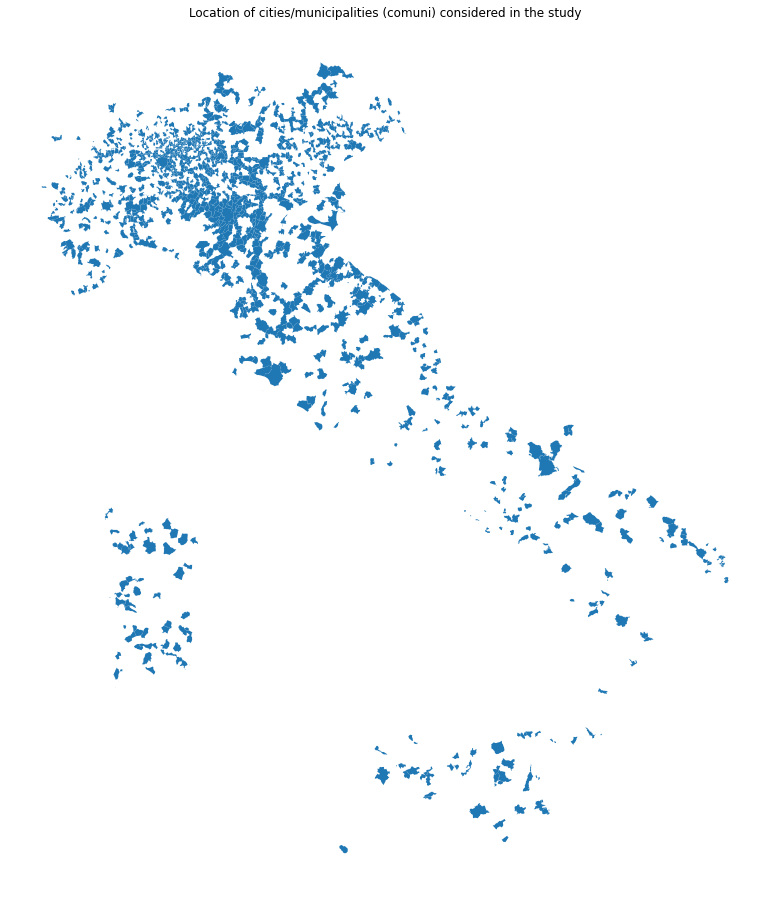

In [30]:
f, ax = mplt.subplots(1, figsize=(16, 16))
geodata.plot(ax=ax)
ax.set_axis_off()
ax.set_title('Location of cities/municipalities (comuni) considered in the study')
mplt.show()

### Figure 2 - Daily and cumulated deaths for all municipalities in the data set

...

In [31]:
leapday = Datetime.datetime({'y':YREF, 'm':2, 'd':29}, fmt='datetime')
spanleap = Datetime.span(since=dstartref, until=leapday)
ileapday = spanleap.days
print('Time series will be padded in position: \033[1m%s\033[0m corresponding to leapday 29/02' % ileapday)

Time series will be padded in position: 59 corresponding to leapday 29/02


...

In [32]:
def plot_one(dat, index = None, one = None, bar=False, dpi=_DPI_,
             marker='v', color='r', linestyle='-', 
             label='',  xlabel='', ylabel='', title = '', 
             xticks = None, xticklabels = None,
             xrottick = False, grid = False,           
             locator = None, formatter = None): 
    if dpi is None:     fig, ax = mplt.subplots()
    else:               fig, ax = mplt.subplots(dpi=dpi)
    if index is None:
        index = dat.index
    if bar is True:
        ax.bar(dat.index.values, 
               dat.loc[index] if one is None else dat.loc[index, one], 
               color=color, label=label)
    else:
        ax.plot(dat.loc[index] if one is None else dat.loc[index, one], 
                c=color, marker=marker, markersize=3, ls=linestyle, lw=0.6,
                label=label)
    ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
    if grid is not False:       ax.grid(linewidth=grid)
    if xticks is not None:      ax.set_xticks(xticks)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)            
    if xrottick is not False:   ax.tick_params(axis ='x', labelrotation=xrottick)
    if formatter is not None:   ax.xaxis.set_major_formatter(formatter)
    if locator is not None:     ax.xaxis.set_major_locator(locator)
    ax.set_title(title,  fontsize='medium')
    ax.legend()
    return ax

...

In [33]:
dailydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    print("- field of total deaths in %s: \033[94m%s\033[0m" % (y,TCOL))
    dailydeaths[y] = data.groupby(DAY)[TCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths.columns.get_loc(y)
        dailydeaths.iloc[ileapday,yloc] = dailydeaths.iloc[ileapday-1,yloc]
        
idx_rng = pd.date_range(start=dstartref, end=dendref, freq=timedelta(1))
dailydeaths.set_index(idx_rng, inplace=True)

- field of total deaths in 2015: TOTALE_15
- field of total deaths in 2016: TOTALE_16
- field of total deaths in 2017: TOTALE_17
- field of total deaths in 2018: TOTALE_18
- field of total deaths in 2019: TOTALE_19
- field of total deaths in 2020: TOTALE_20


In [34]:
weeklydeaths = dailydeaths.resample('W').mean()

...

In [35]:
years_exc = years.copy()
years_exc.remove(YEAR)
avdailydeathsexc = dailydeaths[years_exc].mean(axis = 1, skipna =True) 

...

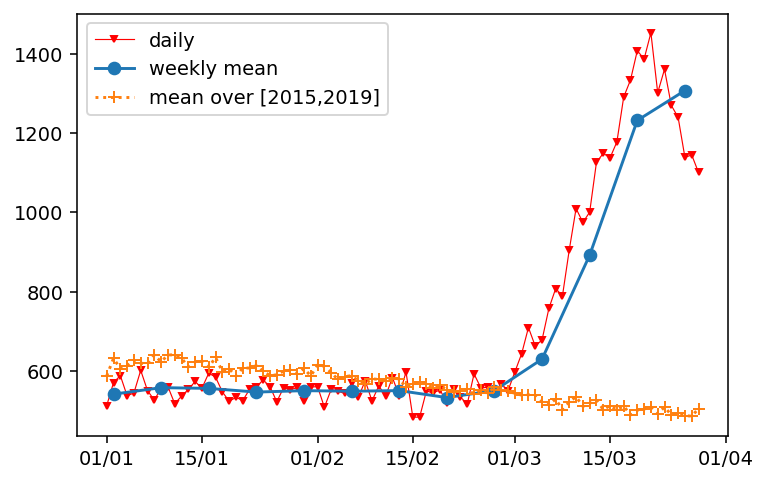

In [36]:
locator = mdates.DayLocator(bymonthday=[1,15]) 
formatter = mdates.DateFormatter('%d/%m')

ax = plot_one(dailydeaths, one = YEAR, index=slice(dstartref,dendref), label='daily',                
              locator = locator, formatter = formatter)
ax.plot(weeklydeaths.loc[dstartref:dendref, YEAR],
        marker='o', markersize=6, linestyle='-', label='weekly mean')
ax.plot(avdailydeathsexc.loc[dstartref:dendref],
        marker='+', linestyle=':',
        label='mean over [%s,%s]' % (min(years_exc),max(years_exc)))
ax.legend()

...

In [37]:
def plot_oneversus(dat, index = None, one = None, versus = None,  dpi=_DPI_,
                   xlabel='', ylabel='', title = '', legend = None,                 
                   grid = False, locator = None, formatter = None):    
    if dpi is None:     fig, ax = mplt.subplots()
    else:               fig, ax = mplt.subplots(dpi=dpi)
    if index is None:
        index = dat.index
    if one is not None:
        ax.plot(dat.loc[index,one], ls='-', lw=0.6, c='r', 
                marker='v', markersize=6, fillstyle='none')
        next(ax._get_lines.prop_cycler)
    if versus is None:
        versus = dat.columns
        try:    versus.remote(one)
        except: pass
    ax.plot(dat.loc[index,versus], ls='None', marker='o', fillstyle='none')
    ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
    if grid is not False:       ax.grid(linewidth=grid)
    if locator is not None:     ax.xaxis.set_major_locator(locator)
    if formatter is not None:   ax.xaxis.set_major_formatter(formatter)
    ax.set_title(title, fontsize='medium')
    if legend is None:
        legend = [one]
        legend.extend(versus)
    ax.legend(legend)
    return ax

...

In [38]:
cumdailydeaths = dailydeaths.cumsum(axis = 0, skipna =True) # default

...

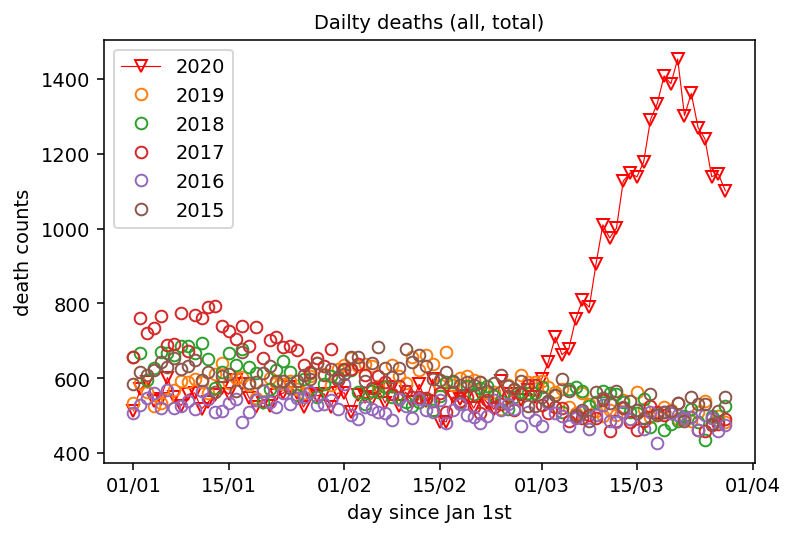

In [39]:
plot_oneversus(dailydeaths, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', ylabel='death counts', 
            title = 'Dailty deaths (all, total)',                
            locator = locator, formatter = formatter)

...

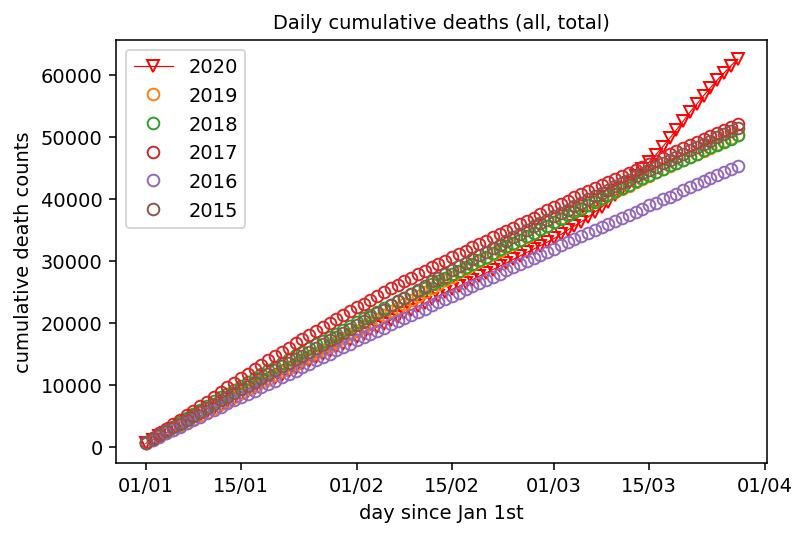

In [40]:
plot_oneversus(cumdailydeaths, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', ylabel='cumulative death counts', 
            title = 'Daily cumulative deaths (all, total)',                
            locator = locator, formatter = formatter)

### Figures 3 - Age distribution of total deaths in the period 15-21 March

...

In [41]:
dstart = get_datetime('0315',YREF)   
week = dstart.isocalendar()[1]
dend = dstart + timedelta(6) # ddays[-1] 
ddays = ['%02d%02d' % (d.month,d.day) for d in [dstart + timedelta(i) for i in range(6)]]

...

In [42]:
AGE = dIT.meta.get('index')['age']['name']
print("- field of age classes: \033[94m%s\033[0m" % AGE)

ageofdeaths = dict.fromkeys(['t','f','m'])
for k in ageofdeaths.keys():
    deaths = pd.DataFrame()
    for y in years:
        COL = dIT.meta.get('index')['%s_%s' % (k,str(y)[2:])]['name']
        print("- field of \033[94m%s\033[0m deaths in %s: \033[94m%s\033[0m" % (k.upper(),y,COL))
        d = data.groupby([AGE,DAY])[COL].agg('sum') #.reindex(idx_rng)
        if leapday >= dstart and leapday <= dend:
            # ispan = Datetime.span(since=dstart, until=leapday)
            # d.iloc[ileapday] = d.iloc[ileapday-1]
            pass
        deaths[y] = d[d.index.get_level_values(DAY).isin(ddays)].groupby(AGE).agg('sum')
    ageofdeaths.update({k: deaths})

- field of age classes: CL_ETA
- field of T deaths in 2015: TOTALE_15
- field of T deaths in 2016: TOTALE_16
- field of T deaths in 2017: TOTALE_17
- field of T deaths in 2018: TOTALE_18
- field of T deaths in 2019: TOTALE_19
- field of T deaths in 2020: TOTALE_20
- field of F deaths in 2015: FEMMINE_15
- field of F deaths in 2016: FEMMINE_16
- field of F deaths in 2017: FEMMINE_17
- field of F deaths in 2018: FEMMINE_18
- field of F deaths in 2019: FEMMINE_19
- field of F deaths in 2020: FEMMINE_20
- field of M deaths in 2015: MASCHI_15
- field of M deaths in 2016: MASCHI_16
- field of M deaths in 2017: MASCHI_17
- field of M deaths in 2018: MASCHI_18
- field of M deaths in 2019: MASCHI_19
- field of M deaths in 2020: MASCHI_20


...

- range of age classes: {'0': '0', '1': '1-4', '2': '5-9', '3': '10-14', '4': '15-19', '5': '20-24', '6': '25-29', '7': '30-34', '8': '35-39', '9': '40-44', '10': '45-49', '11': '50-54', '12': '55-59', '13': '60-64', '14': '65-69', '15': '70-74', '16': '75-79', '17': '80-84', '18': '85-89', '19': '90-94', '20': '95-99', '21': '100+'}


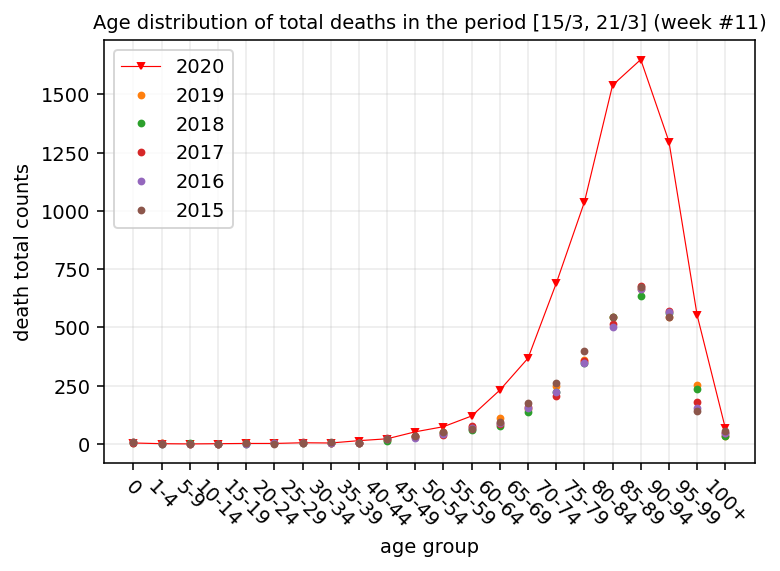

In [43]:
FORMATTER = dIT.meta.get('index')['age']['values']
print("- range of age classes: \033[94m%s\033[0m" % FORMATTER)

ax = plot_one(ageofdeaths['t'], one = YEAR, label = YEAR,
              marker = 'v', color = 'r', linestyle = '-', 
              xrottick = -45, grid = 0.2,
              xlabel = 'age group', 
              ylabel = 'death total counts',
              title = 'Age distribution of total deaths in the period [%s/%s, %s/%s] (week #%s)' % 
                      (*get_daymonth(dstart), *get_daymonth(dend), week) , 
              xticks = list(range(len(FORMATTER.keys()))),
              xticklabels = list(FORMATTER.values())
              )
next(ax._get_lines.prop_cycler)
ax.plot(ageofdeaths['t'][years_exc[::-1]],
        marker='o', markersize=3, linestyle='None')
ax.legend(years[::-1]) 

### Figure 4 - Relative increment of 2020 over baseline in 15-21 March per age group

...

In [44]:
for k in ageofdeaths.keys():
    deaths = ageofdeaths[k]
    deaths['base'] = deaths[years_exc].mean(axis = 1)
    deaths['rinc'] = deaths[YEAR].sub(deaths.base).div(deaths.base)

...

In [45]:
astart, aend = 11, 20
rages, sages = range(astart, aend), slice(astart, aend)

...

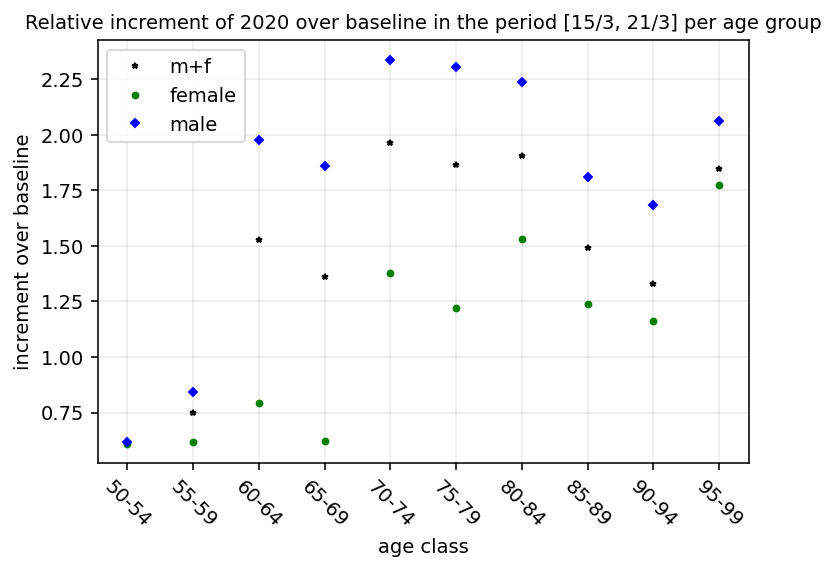

In [46]:
FORMATTER = dIT.meta.get('index')['age']['values']
def func_formater(val, pos):
    try:        return FORMATTER[str(int(val))]
    except:     return ''

ax = plot_one(ageofdeaths['t'], index = sages, one = 'rinc',
              marker = '*', color = 'k', linestyle = 'None', 
              xrottick = -45, grid = 0.2,
              xlabel = 'age class', 
              ylabel = 'increment over baseline',
              title = 'Relative increment of %s over baseline in the period [%s/%s, %s/%s] per age group' %
                (YEAR, *get_daymonth(dstart), *get_daymonth(dend)), 
              label = 'm+f',
              formatter = FuncFormatter(func_formater),
              locator = MaxNLocator(integer=True)
              )
ax.plot(ageofdeaths['f'].loc[sages,'rinc'],
        marker='o', color='g', markersize=3, linestyle='None', label='female')
ax.plot(ageofdeaths['m'].loc[sages,'rinc'],
        marker='D', color='b', markersize=3, linestyle='None', label='male')
ax.legend()

### Figure 5 - Empirical cumulative distribution of excess deaths in 15-21 March 2020 per age group

...

In [47]:
incdeaths = ageofdeaths['t'].apply(lambda row: row[YEAR] - row['base'], axis=1)
cumdeaths = incdeaths.cumsum(axis = 0, skipna =True)

...

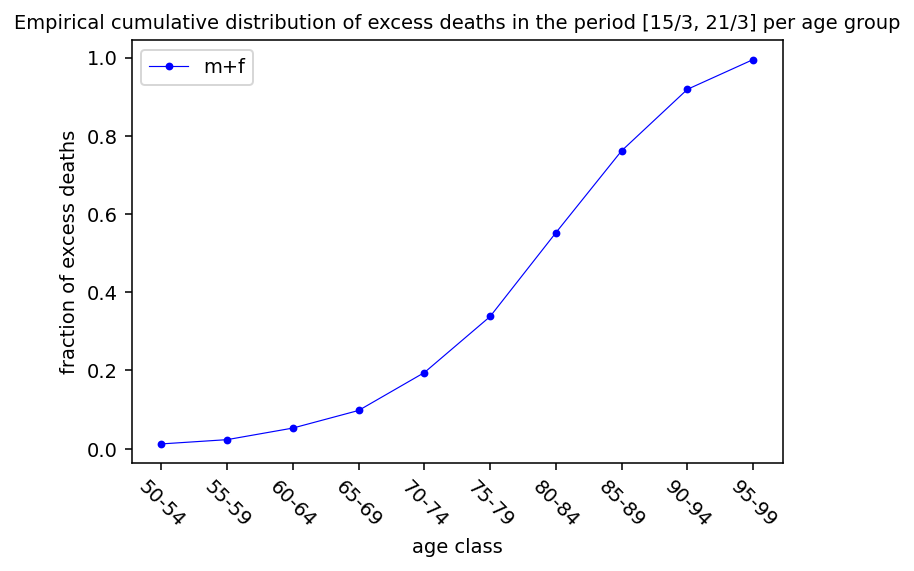

In [48]:
plot_one(cumdeaths/max(cumdeaths), index = sages, 
         marker = 'o', color = 'b', xrottick = -45, 
         xlabel = 'age class', 
         ylabel = 'fraction of excess deaths',         
         title = 'Empirical cumulative distribution of excess deaths in the period [%s/%s, %s/%s] per age group' % 
             (*get_daymonth(dstart), *get_daymonth(dend)), 
         label = 'm+f',
         formatter = FuncFormatter(func_formater),
         locator = MaxNLocator(integer=True)
         )

### Figure 6 - Daily and cumulated deaths of males aged 65+

...

In [49]:
dailydeaths_m65 = pd.DataFrame()
for y in years:
    MCOL = dIT.meta.get('index')['m_%s' % str(y)[2:]]['name'] 
    print("- field of male deaths in %s: \033[94m%s\033[0m" % (y,MCOL))
    dailydeaths_m65[y] = data[data[AGE].isin(rages)].groupby(DAY)[MCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths_m65.columns.get_loc(y)
        dailydeaths_m65.iloc[ileapday,yloc] = dailydeaths_m65.iloc[ileapday-1,yloc]
        
dailydeaths_m65.set_index(idx_rng, inplace=True)

cumdailydeaths_m65 = dailydeaths_m65.cumsum(axis = 0)

- field of male deaths in 2015: MASCHI_15
- field of male deaths in 2016: MASCHI_16
- field of male deaths in 2017: MASCHI_17
- field of male deaths in 2018: MASCHI_18
- field of male deaths in 2019: MASCHI_19
- field of male deaths in 2020: MASCHI_20


...

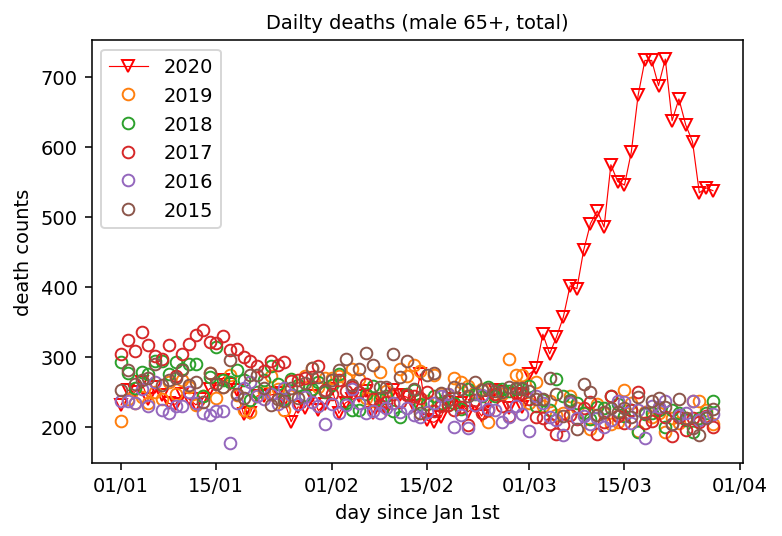

In [50]:
locator = mdates.DayLocator(bymonthday=[1,15]) # mdates.WeekdayLocator(interval=2)
formatter = mdates.DateFormatter('%d/%m')

plot_oneversus(dailydeaths_m65, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', 
            ylabel='death counts', 
            title = 'Dailty deaths (male 65+, total)',                
            locator = locator, formatter = formatter)

...

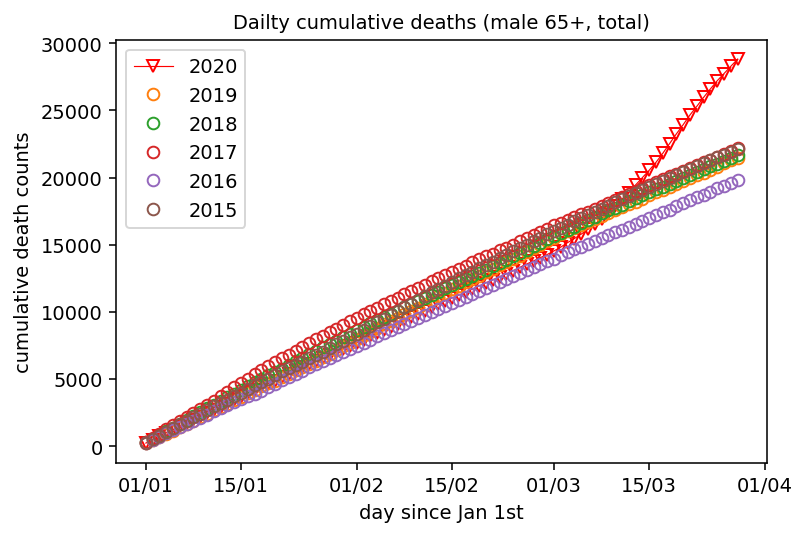

In [51]:
plot_oneversus(cumdailydeaths_m65, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', 
            ylabel='cumulative death counts', 
            title = 'Dailty cumulative deaths (male 65+, total)',                
            locator = locator, formatter = formatter)

### Figure 7 - Total deaths in the period 1-21 March per individual municipalities

...

In [52]:
CITY_CODE = dIT.meta.get('index')['city_code']['name']
PROV_CODE = dIT.meta.get('index')['prov_code']['name']
PROVINCE = dIT.meta.get('index')['province']['name']

cities = data.loc[:,[CITY, CITY_CODE, PROVINCE, PROV_CODE]].drop_duplicates()
comuni = ['Albino', 'Bergamo', 'Brescia', 'Codogno', 'Crema', 
          'Milano', 'Nembro', 'Parma', 'Piacenza', 'San Giovanni Bianco']
comunitable = cities.loc[cities[CITY].isin(comuni)]
comunitable.set_index(comunitable[CITY_CODE], inplace=True)

...

In [53]:
data['refdate'] = data[DAY].apply(lambda row: get_datetime(row, YREF))

...

In [54]:
dstart = get_datetime('0301',YREF)
dend = get_datetime('0321',YREF)

citydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    citydeaths[y] = data[data['refdate'].between(dstart, dend, inclusive=True)]   \
        .groupby(CITY_CODE)[TCOL].agg('sum')
citydeaths['base'] = citydeaths.loc[:,years_exc].max(axis=1)

...

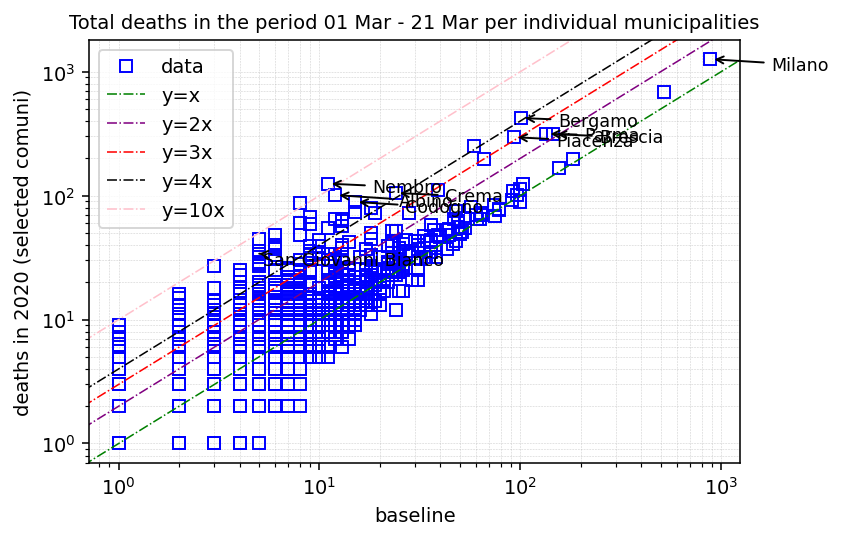

In [55]:
fig, ax = mplt.subplots(dpi=_DPI_)
citydeaths.plot(loglog=True,  x='base', y=YEAR, # kind='scatter',
                     ls='None', color='b', marker='s', fillstyle='none',
                     label='data', ax=ax)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
x = np.arange(0, 10**4, 1)
for i, c in zip([1,2,3,4,10], ['g', 'purple', 'red', 'k', 'pink']):    
    ax.loglog(x, i * x, label = 'y=%sx' % ('' if i==1 else str(i)), ls='-.', lw=0.8, c=c)
ax.set_xlim(xlim), ax.set_ylim(ylim)
ax.grid(linewidth=0.3, which="both", ls='dotted')

for index in comunitable.index:
    xpos, ypos = citydeaths.loc[index,'base'], citydeaths.loc[index,YEAR]
    r = np.random.random() +1
    ax.annotate(comunitable.loc[index,CITY], 
                (xpos, ypos), 
                xytext=(xpos+r*10**np.log10(xpos), ypos-r*10**(np.log10(ypos)-1)),  
                arrowprops=dict(arrowstyle='->'), 
                size=9, ha='center')
ax.set_xlabel('baseline')
ax.set_ylabel('deaths in %s (selected comuni)' % YEAR)
ax.set_title('Total deaths in the period %s - %s per individual municipalities' % 
             (Datetime.datetime(dstart, fmt='%d %b'), Datetime.datetime(dend, fmt='%d %b')),  fontsize='medium'),
ax.legend()

...

In [56]:
citydeaths['rinc'] = citydeaths[YEAR].sub(citydeaths.base).div(citydeaths.base)
citydeaths[PRO_COM_T] = citydeaths.index

geodata = geodata.merge(citydeaths, on=PRO_COM_T)
geodata.head(5)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,...,SHAPE_LEN,geometry,2015,2016,2017,2018,2019,2020,base,rinc
0,1,1,1,201,201,1006,001006,Almese,None,0,...,17058.439037,"POLYGON ((376934.962 4999073.854, 376960.555 4...",2,1,2,3,2,3,3,0.000000
1,1,1,1,201,201,1020,001020,Banchette,None,0,...,13861.181642,"MULTIPOLYGON (((410556.045 5035845.088, 410737...",3,1,1,4,1,6,4,0.500000
2,1,1,1,201,201,1066,001066,Castellamonte,None,0,...,56627.197389,"MULTIPOLYGON (((399851.593 5035334.590, 399858...",6,10,6,3,9,9,10,-0.100000
3,1,1,1,201,201,1024,001024,Beinasco,None,0,...,18927.661943,"POLYGON ((389377.696 4987362.417, 389538.013 4...",16,11,9,17,18,27,18,0.500000
4,1,1,1,201,201,1139,001139,Luserna San Giovanni,None,0,...,31182.577534,"POLYGON ((362241.646 4966621.595, 362247.927 4...",9,7,12,9,12,11,12,-0.083333


...

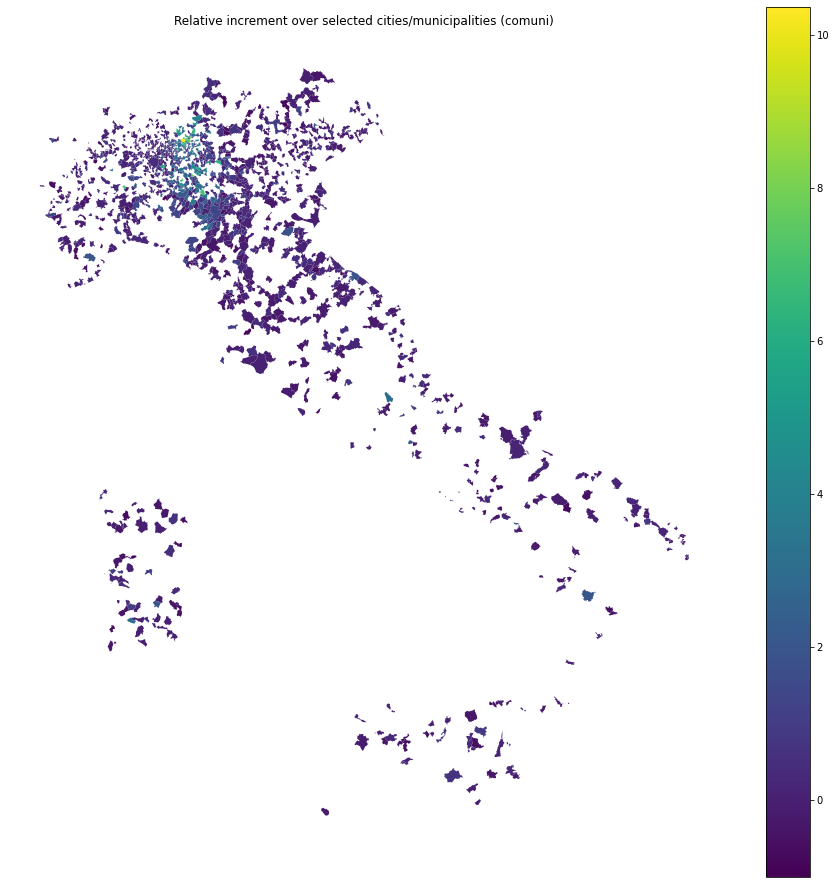

In [57]:
f, ax = mplt.subplots(1, figsize=(16, 16))
geodata.plot(column='rinc', legend=True, ax=ax)
ax.set_axis_off()
ax.set_title('Relative increment over selected cities/municipalities (comuni)')
mplt.show()

### Figure 8 - Codogno (LO)

...

In [58]:
codogno = 'Codogno'
provincia = cities.loc[cities[CITY]==codogno].loc[:,[PROVINCE,PROV_CODE]].values.tolist()[0]

...

In [59]:
dailydeaths = pd.DataFrame()
for y in years:
    TCOL = dIT.meta.get('index')['t_%s' % str(y)[2:]]['name'] 
    dailydeaths[y] = data[data[PROV_CODE]==provincia[1]].groupby(DAY)[TCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths.columns.get_loc(y)
        dailydeaths.iloc[ileapday,yloc] = dailydeaths.iloc[ileapday-1,yloc]
        
idx_rng = pd.date_range(start=dstartref, end=dendref, freq=timedelta(1))
dailydeaths.set_index(idx_rng, inplace=True)

cumdailydeaths = dailydeaths.cumsum(axis = 0)

...

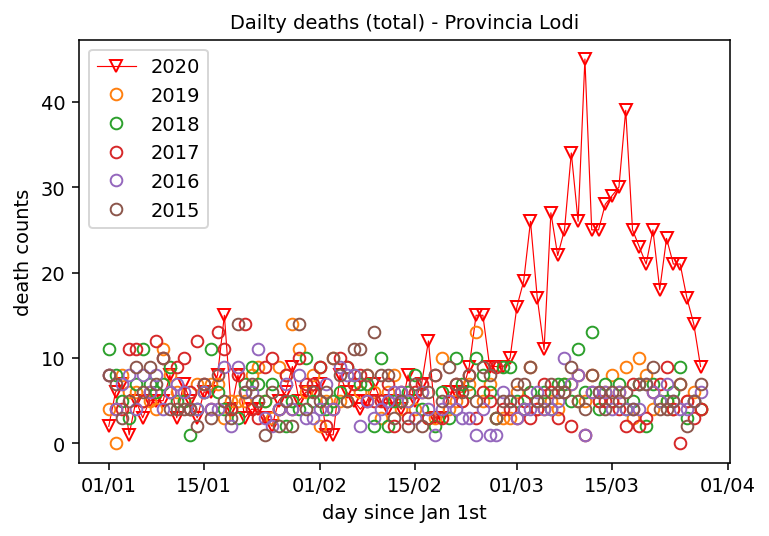

In [60]:
locator = mdates.DayLocator(bymonthday=[1,15]) 
formatter = mdates.DateFormatter('%d/%m')

plot_oneversus(dailydeaths, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', ylabel='death counts', 
            title = 'Dailty deaths (total) - Provincia %s' % provincia[0],                
            locator = locator, formatter = formatter)

...

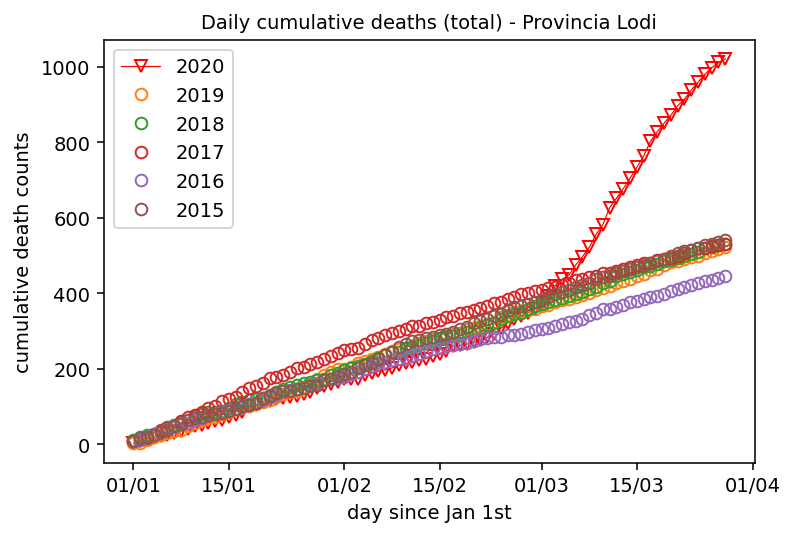

In [61]:
plot_oneversus(cumdailydeaths, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', ylabel='cumulative death counts', 
            title = 'Daily cumulative deaths (total) - Provincia %s' % provincia[0],                
            locator = locator, formatter = formatter)

...

In [62]:
dailydeaths_m65 = pd.DataFrame()
for y in years:
    MCOL = dIT.meta.get('index')['m_%s' % str(y)[2:]]['name'] 
    dailydeaths_m65[y] = data[(data[PROV_CODE]==provincia[1]) & (data[AGE].isin(rages))].groupby(DAY)[MCOL].agg('sum')
    if not calendar.isleap(y):
        yloc = dailydeaths_m65.columns.get_loc(y)
        dailydeaths_m65.iloc[ileapday,yloc] = dailydeaths_m65.iloc[ileapday-1,yloc]
        
dailydeaths_m65.set_index(idx_rng, inplace=True)

cumdailydeaths_m65 = dailydeaths_m65.cumsum(axis = 0)

...

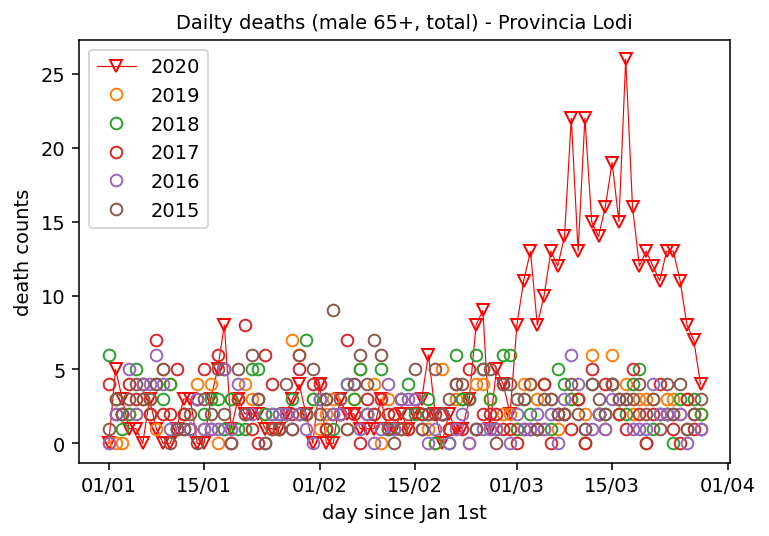

In [63]:
locator = mdates.DayLocator(bymonthday=[1,15]) # mdates.WeekdayLocator(interval=2)
formatter = mdates.DateFormatter('%d/%m')

plot_oneversus(dailydeaths_m65, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', 
            ylabel='death counts', 
            title = 'Dailty deaths (male 65+, total) - Provincia %s' % provincia[0],                
            locator = locator, formatter = formatter)

...

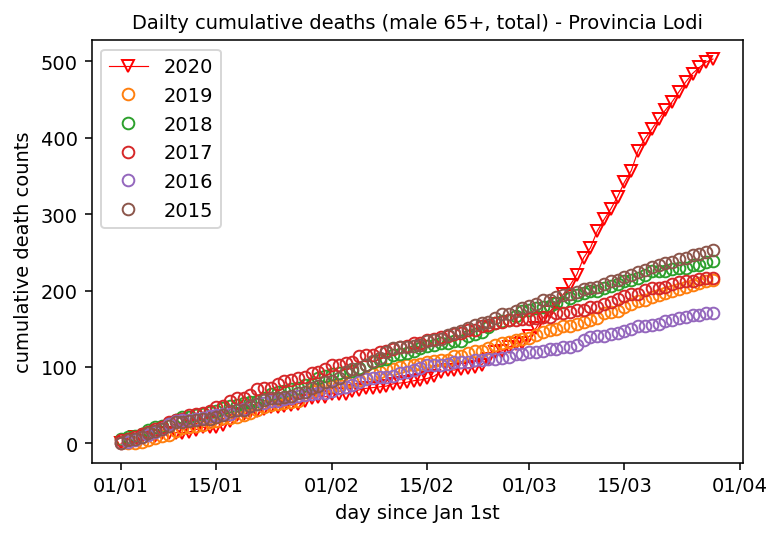

In [64]:
plot_oneversus(cumdailydeaths_m65, one = YEAR, versus = years_exc[::-1],
            xlabel='day since Jan 1st', 
            ylabel='cumulative death counts', 
            title = 'Dailty cumulative deaths (male 65+, total) - Provincia %s' % provincia[0],                
            locator = locator, formatter = formatter)